In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpmath import mp, mpf, exp
import seaborn as sns  
from scipy.stats import norm
import random
from statsmodels.graphics.tsaplots import plot_acf
from scipy.integrate import odeint  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Aplicación del modelo SEIR
PM=127000000
#Valores observados. 
observaciones=np.array([15,	26,	41,	53,	82,	93,	118,	164,	203,	251,	316,	367,	405,	475,	585,	717, 848,	993,	1094,	1215,	1378,	1510,	1688,1890,2143,2439,2785,3118])/PM
#si un individuo no presenta síntomas pero sí puede contagiar a otros lo contabilizamos en I(t), no en E(t)

def ODE(iniciales,tiempo,B,sigma, gamma):
    S, E, I, R= iniciales
    dS=-B*S*I  #ecuacion
    dE=B*S*I-sigma*E
    dI=sigma*E-gamma*I
    dR=gamma*I
    return([dS,dE,dI,dR])

# definimos los puntos iniciales
Et0=0
It0=observaciones[0] #127 representa la población de México al 2020
St0=1-It0
Rt0=0
t=np.arange(0,len(observaciones))
#S1=odeint(ODE,[St0,Et0,It0,Rt0],t, args=(8.36922937, 2.00674359, 6.84754926))
#plt.plot(S1[:,2]*PM)

In [ ]:
#Vamos a calcular la verosimilitud
#suponemos una a priori para beta N(0.2,0.1)
#p_exp = np.frompyfunc(mp.exp, 1, 1)
def logverosimilitud(beta,sigma,gamma):  #PRIORI EXPONENCIAL PARA LAMBDA
  if(beta<0 or sigma<0 or gamma<0):
    return(0)
  else:
    r=np.sum((np.transpose(observaciones)-odeint(ODE,[St0,Et0,It0,Rt0],t, args=(beta, sigma,gamma))[:,2] )**2)  # los valores y observados menos la aproximacion del ode
    return(-1/2*(r+(beta)+(gamma-5)**2+(sigma-1)**2))

def hib(muestra, burnin,lag,ini):
  mean = [0, 0,0]      #propuesta para la normal bivariada
  cov = [[1, 0,0], [0,1,0 ],[0,0,1]]  
  mylist=ini
  aceptaciones=0
  for i in range(burnin+lag*muestra):
    unif1=random.random()  #nos dice al kernel a  que debemos movernos.
    if unif1 < 0.01:                            #####Kernel cero######### 
      mylist=np.r_[mylist,ini]
      aceptaciones=aceptaciones+1
    if unif1 >= 0.01 and unif1 < 0.25: #movimiento simétrico en el parámetro beta   ####movimiento 1########
      propuesta=ini+np.array([float(np.random.normal(0,1,1)),0,0])   #segundo kernel
      unif2 = random.random()      #segunda uniforme para ver si aceptamos
      hoodp=logverosimilitud(propuesta[0,0],propuesta[0,1],propuesta[0,2])
      hoodi=logverosimilitud(ini[0,0],ini[0,1],ini[0,2])
      if (propuesta[0,0] <0 or propuesta[0,1] <0 or propuesta[0,2] < 0):
        ro=0
      else:
         ro=min(1,np.exp(np.float128(hoodp-hoodi)))   #el valor de ro por el desplazamiento simétrico
      if random.random() < ro:  #si se cumple, acepatamos la propuesta
        mylist=np.r_[mylist,propuesta]
        ini=propuesta
        aceptaciones=aceptaciones+1
      else:
        mylist=np.r_[mylist,ini]  #si no se acepta se queda con el anterior

    if unif1 >=0.25 and unif1 < 0.50:   ################ tercer kernel.############## desplazamiento simétrico para el parámetro sigma
      propuesta=ini+np.array([0,float(np.random.normal(0,1,1)),0])
      unif2 = random.random()      #segunda uniforme para ver si aceptamos
      hoodp=logverosimilitud(propuesta[0,0],propuesta[0,1],propuesta[0,2])
      hoodi=logverosimilitud(ini[0,0],ini[0,1],ini[0,2])
      if (propuesta[0,0] <0 or propuesta[0,1] <0 or propuesta[0,2] < 0):
        ro=0
      else:
         ro=min(1,np.exp(np.float128(hoodp-hoodi))) 
        #el valor de ro por el desplazamiento simétrico
      if random.random() < ro:  #si se cumple, acepatamos la propuesta
        mylist=np.r_[mylist,propuesta]
        ini=propuesta
        aceptaciones=aceptaciones+1
      else:
        mylist=np.r_[mylist,ini]  # si no se acepta
    
    if unif1 >=0.50 and unif1 < 0.75: #desplazamiento normal multivariado   #####CUARTO KERNEL, MULTIVARIADO####
      propuesta=ini+np.random.multivariate_normal(mean, cov, 1)  #cuarto kernel 
      unif2 = random.random()      #segunda uniforme para ver si aceptamos
      hoodp=logverosimilitud(propuesta[0,0],propuesta[0,1],propuesta[0,2])
      hoodi=logverosimilitud(ini[0,0],ini[0,1],ini[0,2])
      if(propuesta[0,0] <0 or propuesta[0,1] <0 or propuesta[0,2] < 0):
        ro=0
      else:
         ro=min(1,np.exp(np.float128(hoodp-hoodi)))  #el valor de ro por el desplazamiento simétrico
      if random.random() < ro:  #si se cumple, acepatamos la propuesta
        mylist=np.r_[mylist,propuesta]
        ini=propuesta
        aceptaciones=aceptaciones+1
      else:
        mylist=np.r_[mylist,ini]
    if unif1 >=.75:   ################QUINTO KERNEL.############## desplazamiento simétrico para el parámetro sigma
      propuesta=ini+np.array([0,0,float(np.random.normal(0,1,1))])
      unif2 = random.random()      #segunda uniforme para ver si aceptamos
      hoodp=logverosimilitud(propuesta[0,0],propuesta[0,1],propuesta[0,2])
      hoodi=logverosimilitud(ini[0,0],ini[0,1],ini[0,2])
      if(propuesta[0,0] <0 or propuesta[0,1] <0 or propuesta[0,2] < 0):
        ro=0
      else:
         ro=min(1,np.exp(np.float128(hoodp-hoodi))) 
      if random.random() < ro:  #si se cumple, acepatamos la propuesta
        mylist=np.r_[mylist,propuesta]
        ini=propuesta
        aceptaciones=aceptaciones+1
      else:
        mylist=np.r_[mylist,ini]  # si no se acepta
  #return(np.r_[np.array([[aceptaciones/burnin+lag*muestra,0,0]]),mylist])
  return(mylist)


In [ ]:
muestra1=hib(500000,1,1,np.array([[30,50,0]]))

Text(0.5, 0.92, 'Kerneles híbridos')

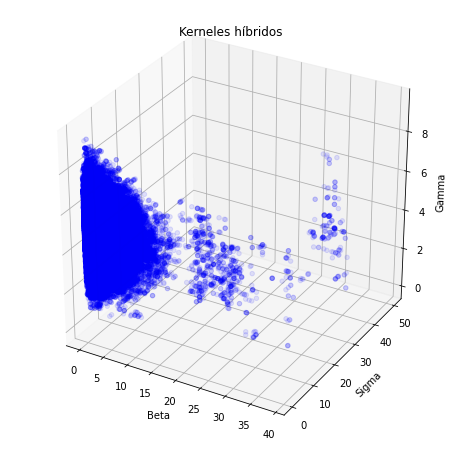

In [ ]:

fig = plt.figure(figsize=(8,8))    #Creamos la figura
ax = fig.add_subplot(111, projection='3d') 
ax.scatter(muestra1[:,0],muestra1[:,1],muestra1[:,2],c='b',marker='o', alpha=0.1)
ax.set_xlabel("Beta")
ax.set_ylabel("Sigma")
ax.set_zlabel("Gamma")
ax.set_title("Kerneles híbridos")

In [ ]:
muestra1[len(muestra1)-1,:] ##200K

array([0.13472512, 1.09258069, 4.28615764])

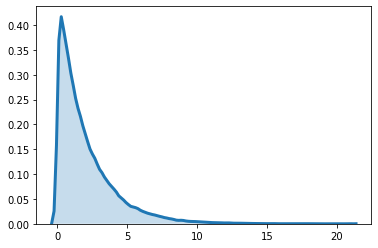

In [ ]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(muestra1[10000:len(muestra1)-1,0], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})


In [ ]:
muestra2=hib(100000,1,1,np.array([[50,50,50]]))

/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Text(0.5, 0.92, 'Kerneles híbridos')

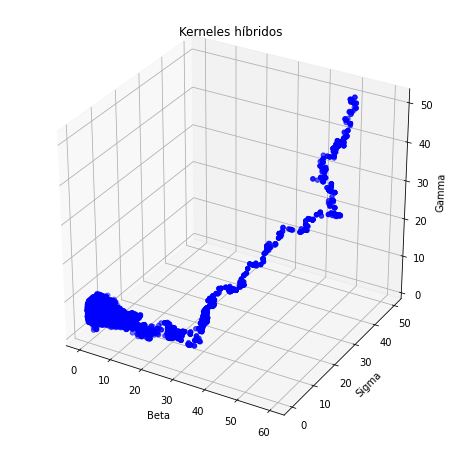

In [ ]:

fig = plt.figure(figsize=(8,8))    #Creamos la figura
ax = fig.add_subplot(111, projection='3d') 
ax.scatter(muestra2[:,0],muestra2[:,1],muestra2[:,2],c='b',marker='o')
ax.set_xlabel("Beta")
ax.set_ylabel("Sigma")
ax.set_zlabel("Gamma")
ax.set_title("Kerneles híbridos")